# OpenAI, Consumer based sentiment Analysis

-- To Be Written --

## Data Collection

In [ ]:
import os
import asyncio
import pandas as pd
import json
import datetime
from asyncpraw import Reddit
from asyncpraw.models import MoreComments

# Load Reddit API credentials from environment variables
USERNAME = os.getenv('USER')
if not USERNAME:
    raise ValueError("USER environment variable not set")

PASSWORD = os.getenv('PASSWORD')
if not PASSWORD:
    raise ValueError("PASSWORD environment variable not set")

CLIENT_ID = os.getenv('CLIENT_ID')
if not CLIENT_ID:
    raise ValueError("CLIENT_ID environment variable not set")

CLIENT_SECRET = os.getenv('CLIENT_SECRET')
if not CLIENT_SECRET:
    raise ValueError("CLIENT_SECRET environment variable not set")


async def create_reddit_instance():
    reddit = Reddit(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        user_agent="my user agent",
        username=USERNAME,
        password=PASSWORD,
    )
    
    # Enable rate limit handling
    reddit.requestor.rate_limit_sleep = True  # Auto-handles rate-limiting
    return reddit


def load_csv_data(file_path):
    """
    Reads the CSV file and groups the queries by post_id.
    Ensures that all query values are strings before joining.
    Returns a dictionary mapping post_id -> query string.
    """
    df = pd.read_csv(file_path)

    # Convert queries to strings and handle NaN values
    df["query"] = df["query"].fillna("").astype(str)

    # Group by post_id and join unique queries with a semicolon.
    grouped = df.groupby("post_id")["query"].apply(lambda x: ";".join(set(x))).reset_index()
    mapping = dict(zip(grouped["post_id"], grouped["query"]))

    return mapping


async def fetch_post_and_comments(reddit, post_id):
    """
    Fetches the submission and its top 10 first-level comments.
    Returns a list of dictionaries containing post and comment details.
    In case of an error, returns one dictionary with error details.
    """
    rows = []
    try:
        submission = await reddit.submission(id=post_id)  # Await here
        
        # Load submission details
        await submission.load()
        
        # Fetch top-level comments (limit: 10)
        await submission.comments.replace_more(limit=10)
        top_comments = submission.comments[:10]

        submission_details = {
            "post_id": submission.id,
            "subreddit": submission.subreddit.display_name,
            "post_title": submission.title,
            "post_body": submission.selftext,
            "number_of_comments": submission.num_comments,
            "readable_datetime": datetime.datetime.fromtimestamp(submission.created_utc).strftime("%Y-%m-%d %H:%M:%S"),
            "post_author": submission.author.name if submission.author else None,
        }

        if top_comments:
            for comment in top_comments:
                if isinstance(comment, MoreComments):  # Skip "load more" placeholders
                    continue
                row = submission_details.copy()
                row.update({
                    "comment_id": comment.id,
                    "comment_body": comment.body,
                    "number_of_upvotes": comment.score,
                    "comment_author": comment.author.name if comment.author else None,
                })
                rows.append(row)
        else:
            # No comments found; create a row with only post details
            row = submission_details.copy()
            row.update({
                "comment_id": None,
                "comment_body": None,
                "number_of_upvotes": None,
                "comment_author": None,
            })
            rows.append(row)

    except Exception as e:
        print(f"Error fetching data for post_id {post_id}: {e}")
        # Return an error row where key details (like 'subreddit') are None.
        rows.append({
            "post_id": post_id,
            "subreddit": None,
            "post_title": None,
            "post_body": None,
            "number_of_comments": None,
            "readable_datetime": None,
            "post_author": None,
            "comment_id": None,
            "comment_body": None,
            "number_of_upvotes": None,
            "comment_author": None,
        })
    
    return rows


def save_csv(data, file_name):
    """Writes the provided data (a list of dictionaries) to a CSV file."""
    df = pd.DataFrame(data)
    df.to_csv(file_name, index=False)
    print(f"CSV file saved as {file_name}")


def save_json(data, file_name):
    """Writes the provided data (a list of dictionaries) to a JSON file."""
    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, default=str)
    print(f"JSON file saved as {file_name}")


async def countdown(seconds):
    """Displays a countdown timer for the given number of seconds."""
    for remaining in range(seconds, 0, -1):
        print(f"Resuming in {remaining:2d} seconds...", end="\r", flush=True)
        await asyncio.sleep(1)
    print("")  # Move to a new line after countdown


async def main():
    reddit = await create_reddit_instance()
    post_query_mapping = load_csv_data("combined_data.csv")
    all_post_ids = list(post_query_mapping.keys())
    
    # Check for an existing checkpoint (processed post_ids)
    checkpoint_file = "checkpoint.json"
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, "r", encoding="utf-8") as f:
            processed_ids = json.load(f)
        print(f"Resuming from checkpoint: {len(processed_ids)} posts already processed.")
    else:
        processed_ids = []

    # Only process posts that have not yet been processed.
    to_process_all = [post_id for post_id in all_post_ids if post_id not in processed_ids]
    print(f"Total posts to process: {len(to_process_all)}")

    # Maintain a retry counter for each post.
    retries = {post_id: 0 for post_id in to_process_all}
    max_retries = 3  # Maximum attempts per post
    batch_size = 30  # Number of posts to process per mini-batch

    # Define output file names.
    output_csv = "raw_dataset.csv"
    output_json = "raw_dataset.json"

    # If output files already exist, load their data; otherwise, start with an empty list.
    if os.path.exists(output_csv):
        existing_df = pd.read_csv(output_csv)
        output_data = existing_df.to_dict(orient="records")
    else:
        output_data = []

    while to_process_all:
        print(f"\nStarting a round with {len(to_process_all)} posts to process.")
        next_to_process = []  # To hold posts that need to be retried

        # Process posts in mini-batches.
        for i in range(0, len(to_process_all), batch_size):
            batch_ids = to_process_all[i:i+batch_size]
            print(f"\nProcessing mini-batch {i // batch_size + 1} "
                  f"of {((len(to_process_all)-1) // batch_size) + 1} (posts: {batch_ids})")
            
            tasks = [fetch_post_and_comments(reddit, post_id) for post_id in batch_ids]
            results = await asyncio.gather(*tasks)
            
            for post_id, rows in zip(batch_ids, results):
                # If the first row's "subreddit" is None, we assume an error occurred.
                if rows and rows[0]["subreddit"] is None:
                    retries[post_id] += 1
                    if retries[post_id] < max_retries:
                        print(f"Error for post_id {post_id}; retrying (attempt {retries[post_id]}/{max_retries}).")
                        next_to_process.append(post_id)
                    else:
                        print(f"Error for post_id {post_id} after {max_retries} attempts; logging error.")
                        for row in rows:
                            row["query"] = post_query_mapping.get(post_id, "")
                        output_data.extend(rows)
                        processed_ids.append(post_id)
                else:
                    # Successful result.
                    for row in rows:
                        row["query"] = post_query_mapping.get(post_id, "")
                    output_data.extend(rows)
                    processed_ids.append(post_id)
            
            # Incrementally save output after each mini-batch.
            save_csv(output_data, output_csv)
            save_json(output_data, output_json)
            # Update the checkpoint.
            with open(checkpoint_file, "w", encoding="utf-8") as f:
                json.dump(processed_ids, f, indent=4)
            
            print("Mini-batch processed. Waiting 60 seconds before the next mini-batch...")
            await countdown(60)

        if next_to_process:
            print(f"\nRetrying {len(next_to_process)} posts in the next round...\n")
            to_process_all = next_to_process
        else:
            break

    print("All posts processed.")

In [4]:
import nest_asyncio
nest_asyncio.apply()

async def run_async():
    await main()

await run_async()

C:\Users\User\AppData\Local\Temp\ipykernel_34020\1641351664.py:47: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Total posts to process: 9575

Starting a round with 9575 posts to process.

Processing mini-batch 1 of 320 (posts: [' the next era is the niche content producer who produces high quality video content', '1002dom', '1007cpq', '100ayoe', '100ye6s', '101chgd', '101melg', '101ms83', '101o6zx', '101p00n', '102ci8x', '102jcse', '102l28b', '102lbp8', '102lrwi', '102xqim', '1030pti', '1030xji', '1031mz4', '1031yi2', '10346f5', '1035gzm', '103ahhi', '103gran', '103qc9j', '103vj6v', '103w7m4', '103wsie', '103yg7r', '1041tuw'])
Error fetching data for post_id  the next era is the niche content producer who produces high quality video content: received 404 HTTP response
Error fetching data for post_id 1030xji: received 429 HTTP response
Error for post_id  the next era is the niche content producer who produces high quality video content; retrying (attempt 1/3).
Error for post_id 1030xji; retrying (attempt 1/3).
CSV file saved as new_combined_dataset.csv
JSON file saved as new_combined_dataset.json

### Raw-Data Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
# Load dataset
file_path = "Data/raw_dataset.csv"
df = pd.read_csv(file_path)

#### Basic Information

In [4]:
# Display basic information
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54966 entries, 0 to 54965
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   post_id             54966 non-null  object 
 1   subreddit           54954 non-null  object 
 2   post_title          54954 non-null  object 
 3   post_body           30349 non-null  object 
 4   number_of_comments  54954 non-null  float64
 5   readable_datetime   54954 non-null  object 
 6   post_author         54478 non-null  object 
 7   comment_id          54352 non-null  object 
 8   comment_body        54350 non-null  object 
 9   number_of_upvotes   54352 non-null  float64
 10  comment_author      49478 non-null  object 
 11  query               52113 non-null  object 
dtypes: float64(2), object(10)
memory usage: 5.0+ MB


In [5]:
# Sample records
print("\nSample Records:")
display(df.head())


Sample Records:


,post_id,subreddit,post_title,post_body,number_of_comments,readable_datetime,post_author,comment_id,comment_body,number_of_upvotes,comment_author,query
0,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2far1e,Chat GPT wrote this article ffs,792.0,The_Bridge_Imperium,ChatGPT
1,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f5vg2,Did you order the code red?,687.0,damienn22,ChatGPT
2,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f9y5m,If my search engine was littered with SEO keyw...,1288.0,1x2x4x1,ChatGPT
3,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2f7njc,How many more times are we gonna see this story,306.0,frombaktk,ChatGPT
4,1002dom,technology,"ChatGPT Caused 'Code Red' at Google, Report Says",NaN,370.0,2023-01-01 00:03:33,slakmehl,j2fna2c,How far can we trust ChatGPT? It's very intere...,70.0,Milk_Busters,ChatGPT


In [6]:
# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
post_id                   0
subreddit                12
post_title               12
post_body             24617
number_of_comments       12
readable_datetime        12
post_author             488
comment_id              614
comment_body            616
number_of_upvotes       614
comment_author         5488
query                  2853
dtype: int64


In [7]:
# Basic statistics
df["post_title_length"] = df["post_title"].astype(str).apply(len)
df["post_body_length"] = df["post_body"].astype(str).apply(len)
df["comment_body_length"] = df["comment_body"].astype(str).apply(len)

# Unique vs. Duplicate text
unique_titles = df["post_title"].nunique()
unique_bodies = df["post_body"].nunique()
unique_comments = df["comment_body"].nunique()

print("\nUnique vs Duplicate Counts:")
print(f"Unique Post Titles: {unique_titles}/{len(df)}")
print(f"Unique Post Bodies: {unique_bodies}/{len(df)}")
print(f"Unique Comments: {unique_comments}/{len(df)}")



Unique vs Duplicate Counts:
Unique Post Titles: 9426/54966
Unique Post Bodies: 5793/54966
Unique Comments: 51594/54966


#### Charecter Length

In [8]:
# Summary statistics for text lengths = BASED ON CHARECTERS
text_length_stats = pd.DataFrame({
    "Metric": ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"],
    "Post Title Length": [
        df["post_title_length"].min(),
        df["post_title_length"].quantile(0.25),
        df["post_title_length"].median(),
        df["post_title_length"].quantile(0.75),
        df["post_title_length"].max(),
        df["post_title_length"].mean(),
    ],
    "Post Body Length": [
        df["post_body_length"].min(),
        df["post_body_length"].quantile(0.25),
        df["post_body_length"].median(),
        df["post_body_length"].quantile(0.75),
        df["post_body_length"].max(),
        df["post_body_length"].mean(),
    ],
    "Comment Body Length": [
        df["comment_body_length"].min(),
        df["comment_body_length"].quantile(0.25),
        df["comment_body_length"].median(),
        df["comment_body_length"].quantile(0.75),
        df["comment_body_length"].max(),
        df["comment_body_length"].mean(),
    ],
})

# Display the table in a Jupyter Notebook-friendly format
from IPython.display import display
display(text_length_stats)


,Metric,Post Title Length,Post Body Length,Comment Body Length
0,Min,1.000000,1.000000,1.000000
1,25th Percentile,41.000000,3.000000,51.000000
2,Median (50th),63.000000,100.000000,118.000000
3,75th Percentile,94.000000,676.000000,274.000000
4,Max,300.000000,36834.000000,9996.000000
5,Mean,76.353036,745.767129,240.651002


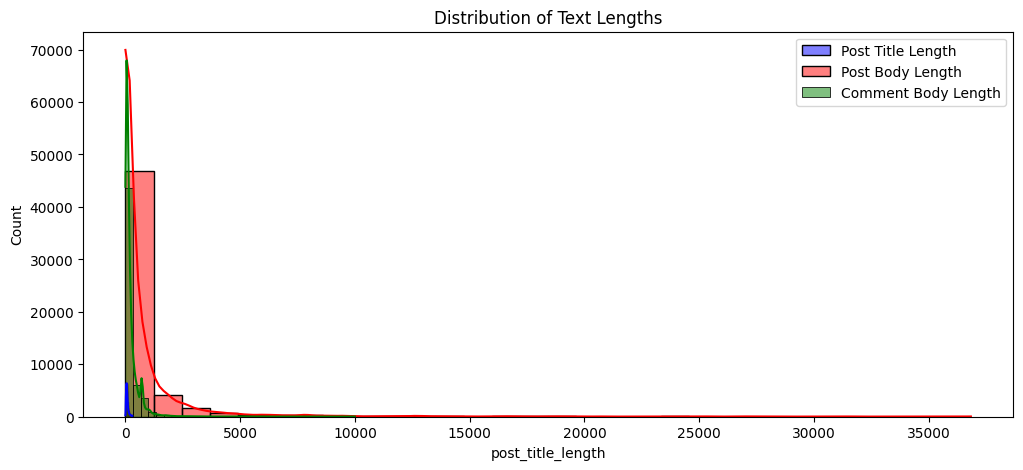

In [9]:
# Plot distribution of text lengths
plt.figure(figsize=(12, 5))
sns.histplot(df["post_title_length"], bins=30, kde=True, color='blue', label="Post Title Length")
sns.histplot(df["post_body_length"], bins=30, kde=True, color='red', label="Post Body Length")
sns.histplot(df["comment_body_length"], bins=30, kde=True, color='green', label="Comment Body Length")
plt.legend()
plt.title("Distribution of Text Lengths")
plt.show()

#### Word Length

In [10]:
df["post_title_word_count"] = df["post_title"].astype(str).apply(lambda x: len(x.split()))
df["post_body_word_count"] = df["post_body"].astype(str).apply(lambda x: len(x.split()))
df["comment_body_word_count"] = df["comment_body"].astype(str).apply(lambda x: len(x.split()))

# Summary statistics for word counts
word_count_stats = pd.DataFrame({
    "Metric": ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"],
    "Post Title Word Count": [
        df["post_title_word_count"].min(),
        df["post_title_word_count"].quantile(0.25),
        df["post_title_word_count"].median(),
        df["post_title_word_count"].quantile(0.75),
        df["post_title_word_count"].max(),
        df["post_title_word_count"].mean(),
    ],
    "Post Body Word Count": [
        df["post_body_word_count"].min(),
        df["post_body_word_count"].quantile(0.25),
        df["post_body_word_count"].median(),
        df["post_body_word_count"].quantile(0.75),
        df["post_body_word_count"].max(),
        df["post_body_word_count"].mean(),
    ],
    "Comment Body Word Count": [
        df["comment_body_word_count"].min(),
        df["comment_body_word_count"].quantile(0.25),
        df["comment_body_word_count"].median(),
        df["comment_body_word_count"].quantile(0.75),
        df["comment_body_word_count"].max(),
        df["comment_body_word_count"].mean(),
    ],
})

# Display the table
display(word_count_stats)

,Metric,Post Title Word Count,Post Body Word Count,Comment Body Word Count
0,Min,1.000000,0.000000,1.00000
1,25th Percentile,7.000000,1.000000,9.00000
2,Median (50th),11.000000,12.000000,20.00000
3,75th Percentile,16.000000,109.000000,47.00000
4,Max,58.000000,5815.000000,1815.00000
5,Mean,13.105593,117.701925,39.56393


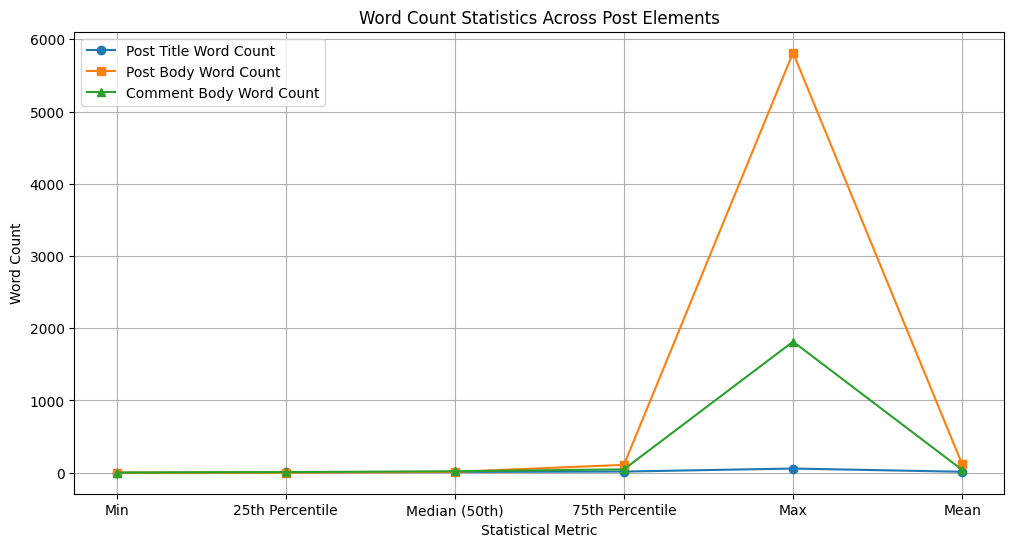

In [11]:
# Define the metrics for x-axis
metrics = ["Min", "25th Percentile", "Median (50th)", "75th Percentile", "Max", "Mean"]
x_labels = range(len(metrics))  # X-axis positions

# Create a figure for word count statistics
plt.figure(figsize=(12, 6))

# Plot lines for each text category
plt.plot(x_labels, word_count_stats["Post Title Word Count"], marker="o", label="Post Title Word Count")
plt.plot(x_labels, word_count_stats["Post Body Word Count"], marker="s", label="Post Body Word Count")
plt.plot(x_labels, word_count_stats["Comment Body Word Count"], marker="^", label="Comment Body Word Count")

# Formatting the plot
plt.xticks(x_labels, metrics)  # Set x-axis labels
plt.ylabel("Word Count")
plt.xlabel("Statistical Metric")
plt.title("Word Count Statistics Across Post Elements")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


#### Sample Data

In [24]:
# Show some examples
print("\nSample Posts and Comments:")
sample_data = df[["post_title", "post_body", "comment_body"]].sample(10, random_state=42)
display(sample_data)


Sample Posts and Comments:


,post_title,post_body,comment_body
47632,AI models now outperform PhD experts in their ...,NaN,I love how he just adds 'exponential' to what ...
28105,Due to the speed of AI development and the lon...,NaN,Academic papers run the gamut from top notch i...
22395,Brad Lightcap (an OpenAI executive) just said ...,https://x.com/legit_rumors/status/178768158049...,So we're getting a great teammate in 12 months...
47673,My 100% human written paragraph was flagged as...,"Many online forms right now, oblige you not to...",This AI Detector is not commonly used. Use som...
54365,"hey guys, it says open A.I is not available in...",But my country is in the Philippines but I cur...,"If you have access to the app telegram, there'..."
10151,Is it me or does Dall-E 3 not produce realisti...,NaN,It’s amazing to be honest
54660,ChatGPT PRO app in the Play Store: Is this legit?,NaN,This doesn't look like something done by OpenA...
3184,OpenAI will discontinue support for their Code...,NaN,Cool - now I can close the tab I had open in m...
19962,GPT-3.5-turbo doesn't complete task,I'm experimenting with API calls to `GPT-3.5-t...,GPT 3.5 has reached its full teenage potential…
1566,Sydney (Bing GPT) is scarily similar to Samant...,\n\nWhen New Bing was announced on the 7th of...,We need waifuGPT


#### Frequency Analysis

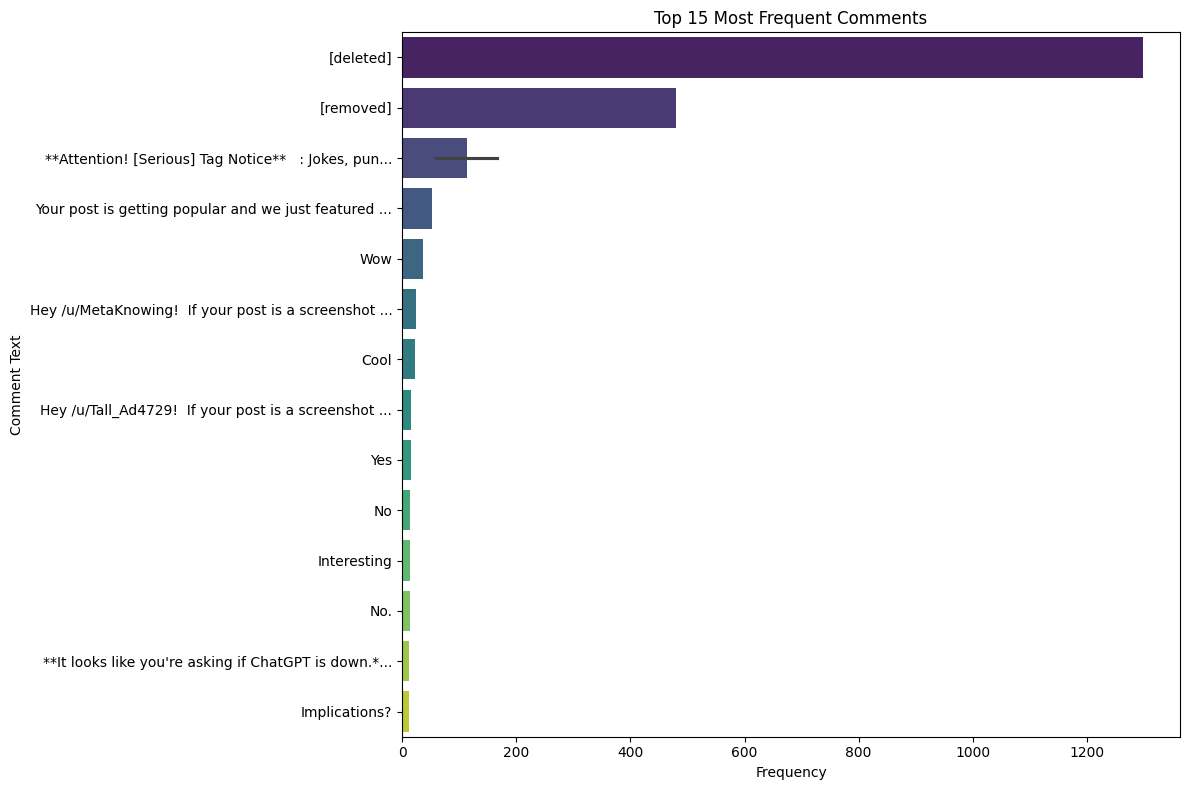

In [30]:
from tabulate import tabulate

# Convert frequency counts to a percentage of total comments
comment_freq = df['comment_body'].value_counts().reset_index()

def clean_comment(comment):
    c = comment.replace('\n', ' ').strip()
    if len(c) > 50:
        return c[:50] + '...'
    return c

# Create a nicely formatted table for display
freq_table = pd.DataFrame({
    'Comment Text': comment_freq['comment_body'].apply(clean_comment),
    'Count': comment_freq['count'],
}).head(15)

# Plot the horizontal bar chart for the top 15 comments
plt.figure(figsize=(12, 8))
sns.barplot(data=freq_table, 
            x='Count', 
            y='Comment Text',
            hue='Comment Text',  
            legend=False, 
            palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Comment Text')
plt.title('Top 15 Most Frequent Comments')
plt.tight_layout()
plt.show()

In [45]:
# Check if there are any non standard Post IDs or Comment IDs

# Standard lenght of the IDs are 6 or 7 characters
# They contain only lowercase letters and digits

# Check for non-standard post IDs (handling NaN values)
non_standard_post_ids = df[~df['post_id'].fillna('').str.match(r'^[a-z0-9]{6,7}$')]  # Regex pattern for post IDs

# Check for non-standard comment IDs (handling NaN values)
non_standard_comment_ids = df[~df['comment_id'].fillna('').str.match(r'^[a-z0-9]{6,7}$')]  # Regex pattern for comment IDs

# Display the counts and post IDs
print("Non-Standard Post IDs:")
print("Count: ", len(non_standard_post_ids))
post_id_df = pd.Series(non_standard_post_ids['post_id'].unique(), name='Post IDs').to_frame()
print(tabulate(post_id_df, headers='keys', tablefmt='psql', showindex=False))

# Display the counts and comment IDs
print("\nNon-Standard Comment IDs:")
print("Count: ", len(non_standard_comment_ids))
comment_id_df = pd.Series(non_standard_comment_ids['comment_id'].unique(), name='Comment IDs').to_frame()
print(tabulate(comment_id_df, headers='keys', tablefmt='psql', showindex=False))



Non-Standard Post IDs:
Count:  12
+------------------------------------------------------------------------------------------------------------------------+
| Post IDs                                                                                                               |
|------------------------------------------------------------------------------------------------------------------------|
| magic                                                                                                                  |
| e22d6                                                                                                                  |
| the next era is the niche content producer who produces high quality video content                                     |
| 24-01-02 02:13:56                                                                                                      |
| > Yet when you watch movies that were shot somewhere between the 50s and the 90s                       

<Figure size 1200x600 with 0 Axes>

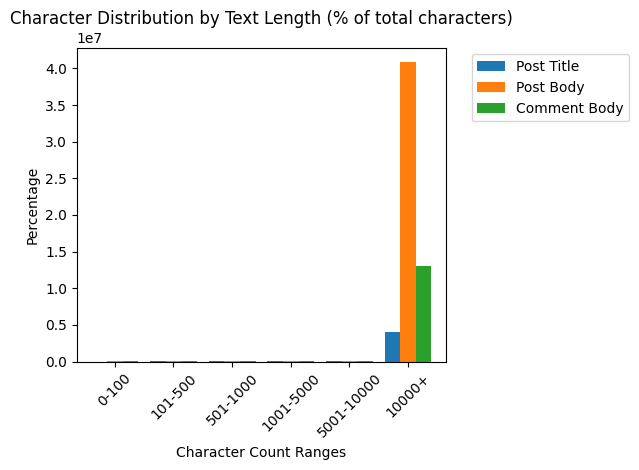

Post Title Character Counts:
count       276.000000
mean      15205.742754
std       59881.758329
min           1.000000
25%           2.000000
50%          11.000000
75%        1239.250000
max      668322.000000
dtype: float64

Post Body Character Counts:
count    5.870000e+02
mean     6.970696e+04
std      4.057647e+05
min      1.000000e+00
25%      9.000000e+00
50%      2.000000e+01
75%      6.750000e+01
max      6.353841e+06
dtype: float64

Comment Body Character Counts:
count    1.060000e+03
mean     1.247715e+04
std      9.990402e+04
min      1.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      9.000000e+00
max      2.104264e+06
dtype: float64


In [53]:
# Define bins for character counts
bins = [0, 100, 500, 1000, 5000, 10000, float('inf')]
labels = ['0-100', '101-500', '501-1000', '1001-5000', '5001-10000', '10000+']

# Count characters for each text field
post_title_chars = Counter(''.join(df['post_title'].fillna('')))
post_body_chars = Counter(''.join(df['post_body'].fillna('')))
comment_body_chars = Counter(''.join(df['comment_body'].fillna('')))

# Function to bin the character counts
def bin_counts(counter):
    binned = {label: 0 for label in labels}
    
    for _, count in counter.items():
        for i, (lower, upper) in enumerate(zip(bins[:-1], bins[1:])):
            if lower <= count < upper:
                binned[labels[i]] += count
                break
                
    return pd.Series(binned)

# Bin the character counts
binned_counts = pd.DataFrame({
    'Post Title': bin_counts(post_title_chars),
    'Post Body': bin_counts(post_body_chars),
    'Comment Body': bin_counts(comment_body_chars)
})

# Create the plot
plt.figure(figsize=(12, 6))
binned_counts.plot(kind='bar', width=0.8)
plt.title('Character Distribution by Text Length (% of total characters)')
plt.xlabel('Character Count Ranges')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


# Print the quartiles for the character counts
print("Post Title Character Counts:")
print(pd.Series(post_title_chars).describe(percentiles=[0.25, 0.5, 0.75]))
print("\nPost Body Character Counts:")
print(pd.Series(post_body_chars).describe(percentiles=[0.25, 0.5, 0.75]))
print("\nComment Body Character Counts:")
print(pd.Series(comment_body_chars).describe(percentiles=[0.25, 0.5, 0.75]))

#### Data Insights

1) Volume and Engagement
    - Dataset contains 54,966 total records
    - 9,426 unique post titles and 51,594 unique comments
    - Only 5,793 unique post bodies, indicating significant content reuse
    - Average of ~39 words per comment, showing concise engagement

2) Content Patterns
    - High percentage of deleted/removed content (1,298 deleted, 480 removed comments)
    - Significant number of automated messages and moderator notices
    - Common short responses like "Wow", "Cool", "Yes" appear frequently

3) Data Quality Issues
    - Some non-standard post IDs identified
    - Missing values in various fields (comment_author, post_body)
    - Presence of automated messages and system notifications affecting data quality
    - Mismatch in No.of missing comment ids and comment bodies

4) Word Count Analysis
    - Post titles: Average of 13 words
    - Post bodies: Average of 118 words
    - Comments: Average of 40 words
    - Shows preference for concise titles and longer post content

5) Distribution Analysis
    - Most text content falls in the 1000+ character range
    - Over 40M characters in post bodies, indicating lengthy discussions
    - Roughly 13M characters in comments, showing substantial engagement
    - Post titles remain concise with most under 1000 characters
    - Comment distribution shows moderate length preferences (500-10000 characters)

# Data Preprocessing

#### Clean data

1) Quality Control
    - Remove records with non-standard post IDs (6-7 characters)
    - Remove records where subreddit is null
    - Clean text formatting:
      - Replace newlines with spaces
      - Re-encode to UTF-8 to handle special characters

2) Text Preprocessing
    - Fill missing values in number_of_upvotes with 0
    - Remove deleted/removed comments
    - Remove comments that appear more than 50 times (likely automated/spam)
    - Remove automated messages matching patterns:
      - Username mentions ("Hey /u/...")
      - Moderation notices
      - Reddit removal notices
      - Text in square brackets

In [114]:
filtered_data = pd.read_csv("Data/raw_dataset.csv")

In [115]:
# Ensure that the post_id is 6 or 7 characters long
filtered_data = filtered_data[filtered_data['post_id'].str.match(r'^[a-z0-9]{6,7}$')]

# Remove all records where subreddit is null
filtered_data = filtered_data[~filtered_data['subreddit'].isnull()]

filtered_data['post_title'] = filtered_data['post_title'].str.replace('\n', ' ')
filtered_data['post_body'] = filtered_data['post_body'].str.replace('\n', ' ')
filtered_data['comment_body'] = filtered_data['comment_body'].str.replace('\n', ' ')

# Reencode the data to utf-8
filtered_data['post_title'] = filtered_data['post_title'].str.encode('utf-8', 'ignore').str.decode('utf-8')
filtered_data['post_body'] = filtered_data['post_body'].str.encode('utf-8', 'ignore').str.decode('utf-8')
filtered_data['comment_body'] = filtered_data['comment_body'].str.encode('utf-8', 'ignore').str.decode('utf-8')

filtered_data['number_of_upvotes'] = filtered_data['number_of_upvotes'].fillna(0)

# Fill empty post_body 
filtered_data['post_body'] = filtered_data['post_body'].fillna('')

# Remove where comment_body is [deleted] or [removed]
filtered_data = filtered_data[filtered_data['comment_body'] != '[deleted]']
filtered_data = filtered_data[filtered_data['comment_body'] != '[removed]']

# Remove comment body when count is greater than 50
# Keep records where comment_body is null or appears <= 50 times
# Create a mask for records where comment_body is null or appears <= 50 times
comment_counts = filtered_data['comment_body'].value_counts()
mask = (filtered_data['comment_body'].isna()) | (filtered_data['comment_body'].map(lambda x: comment_counts.get(x, 0) <= 50))
filtered_data = filtered_data[mask]

# Remove data that matches the regex pattern, handling NaN values
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'^Hey\s+/u/\w+.*?$', regex=True)]
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'^.*?if you have any questions or concerns.*?$', regex=True)]
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'\[ Removed by Reddit \]', regex=True)]
filtered_data = filtered_data[~filtered_data['comment_body'].fillna('').str.contains(r'^.*?\[.*?\].*?$', regex=True)]

# Store the data in a new CSV file
filtered_data.to_csv('cleaned_data.csv', index=False)

# Check number post (has post_id but no comment_id)
print("\nAfter cleaning the data")
print("Number of posts:", len(filtered_data['post_id'].unique()))
print("Posts without comments:", len(filtered_data[filtered_data['comment_id'].isna()]))



After cleaning the data
Number of posts: 8850
Posts without comments: 602


Fix the data category of each field

In [116]:
# Declare each field data type
filtered_data['post_id'] = filtered_data['post_id'].astype(str)
filtered_data['comment_id'] = filtered_data['comment_id'].astype(str)
filtered_data['post_title'] = filtered_data['post_title'].astype(str)
filtered_data['post_body'] = filtered_data['post_body'].astype(str)
filtered_data['post_author'] = filtered_data['post_author'].astype(str)
filtered_data['comment_body'] = filtered_data['comment_body'].astype(str)
filtered_data['comment_author'] = filtered_data['comment_author'].astype(str)
filtered_data['query'] = filtered_data['query'].astype(str)

filtered_data['subreddit'] = filtered_data['subreddit'].astype('category')
filtered_data['query'] = filtered_data['query'].astype('category')

# Fill NaN values with 0 before converting to int
filtered_data['number_of_comments'] = filtered_data['number_of_comments'].fillna(0).astype(int)
filtered_data['number_of_upvotes'] = filtered_data['number_of_upvotes'].fillna(0).astype(int)

filtered_data['readable_datetime'] = pd.to_datetime(filtered_data['readable_datetime'])

print(filtered_data.head())


   post_id   subreddit                                        post_title  \
0  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
1  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
2  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
3  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   
4  1002dom  technology  ChatGPT Caused 'Code Red' at Google, Report Says   

  post_body  number_of_comments   readable_datetime post_author comment_id  \
0                           370 2023-01-01 00:03:33    slakmehl    j2far1e   
1                           370 2023-01-01 00:03:33    slakmehl    j2f5vg2   
2                           370 2023-01-01 00:03:33    slakmehl    j2f9y5m   
3                           370 2023-01-01 00:03:33    slakmehl    j2f7njc   
4                           370 2023-01-01 00:03:33    slakmehl    j2fna2c   

                                        comment_body  number_of_upvotes  \

#### Data consolidation

1. Text Combination
- Created combined text field from comment bodies or Post tite + Post body
- Replaced None/NaN values with empty strings
- Dropped rows with empty text
- Added new rows for unique posts
- Removed duplicate rows

2. Filter by Date
- Imported datetime utilities
- Set cutoff date to 5 years from current date
- Filtered data to only include posts within date range 
- Validated date range of filtered data

3. Text Length Processing
- Removed records with empty/missing text
- Established minimum word count threshold of 3 words
- Calculated word count statistics
- Set maximum word threshold using upper quartile + 1.5*IQR
- Filtered data to include only texts within word count bounds
- Remove Texts above 1024 chars for Embedding Model (iterative descision)

In [117]:
# Create combined text field and replace None/NaN with empty string
filtered_data["text"] = filtered_data.apply(
	lambda row: (
		str(row['comment_body']).strip() if pd.notna(row['comment_body'])
		else ""), 
	axis=1
).fillna("")

# Print count
print("Number of empty texts:", (filtered_data["text"] == "").sum())
print("Number of NA texts:", filtered_data["text"].isna().sum())
print("Total records:", len(filtered_data))

# Drop rows where text is empty
filtered_data = filtered_data[filtered_data["text"] != ""]

# Add a new row for all unique posts (get post_id, comments, and all from first record of the post, exclude any comment fields)
posts = filtered_data.groupby("post_id").first().reset_index()
posts = posts.drop(columns=["comment_id", "comment_body", "comment_author", "text"])

print("\nNumber of posts:", len(posts))

# Make post text the same as post title and post body
posts["text"] = posts["post_title"] + " " + posts["post_body"]

# Concat filtered data and posts
filtered_data = pd.concat([posts, filtered_data], ignore_index=True)

# Remove any duplicate rows
filtered_data = filtered_data.drop_duplicates()

# Display first few rows and value counts of empty strings
print("\nAfter adding new row for all unique posts")
print("Total records:", len(filtered_data))

Number of empty texts: 0
Number of NA texts: 0
Total records: 48389

Number of posts: 8850

After adding new row for all unique posts
Total records: 57239


In [118]:
# No.of Posts and Comments
print("\nStats:")
print("Total Records:", len(filtered_data))
print("Total Posts:", len(filtered_data["post_id"].unique()))
print("Total Comments:", len(filtered_data["comment_id"].unique()))


Stats:
Total Records: 57239
Total Posts: 8850
Total Comments: 47789


###  S1: Filter to past 5 year

In [119]:
from datetime import datetime, timedelta

In [120]:
cutoff_date = datetime.now() - timedelta(days=5*365)

filtered_data = filtered_data[filtered_data["readable_datetime"] > cutoff_date]

print("\nNumber of Posts and Comments after filtering:")
print(filtered_data["post_id"].nunique())
print(filtered_data["comment_id"].count())

# Print date time range in the data
print("\nDate time range:")
print(filtered_data["readable_datetime"].min())
print(filtered_data["readable_datetime"].max())


Number of Posts and Comments after filtering:
8834
48355

Date time range:
2020-05-01 13:26:05
2025-01-30 12:00:03


In [121]:
# Remove all missing records where text is empty
filtered_data = filtered_data[filtered_data["text"] != ""]
filtered_data = filtered_data[filtered_data["text"].notna()]
filtered_data = filtered_data[filtered_data["text"] != "nan"]
filtered_data = filtered_data[filtered_data["text"] != "None"]

### S2: Text Length

Short Texts: Extremely short texts (e.g., those with only one or two words) might not provide enough context and could be noise.

Excessively Long Texts: Conversely, texts that far exceed the typical length for your domain might be off-topic or contain noise.

In [122]:
min_words = 3

# Calculate word counts for each text
word_counts = filtered_data['text'].str.split().str.len()

print("\nWord count statistics:")
print(tabulate([word_counts.describe()], headers='keys'))
print("\n")


# Set max_words as the upper quartile (75th percentile) plus 1.5 times IQR
Q3 = word_counts.quantile(0.75)
Q1 = word_counts.quantile(0.25)
IQR = Q3 - Q1
max_words = int(Q3 + 1.5 * IQR)

print(f"Max words set to: {max_words}")


Word count statistics:
  count    mean      std    min    25%    50%    75%    max
-------  ------  -------  -----  -----  -----  -----  -----
  56592   52.46  141.864      1     10     21     49   5827


Max words set to: 107


In [123]:
print("\nNumber of Posts and Comments before filtering by word count:")
print("Posts:", filtered_data["post_id"].nunique())
print("Comments:", filtered_data["comment_id"].nunique())

# First recalculate word counts since filtered_data has been modified since last count
word_counts = filtered_data['text'].str.split().str.len()

# Store the initial number of records
initial_records = len(filtered_data)

# Filter based on min and max words
filtered_data = filtered_data[word_counts.between(min_words, max_words)]

# Calculate the number of records removed
records_removed = initial_records - len(filtered_data)

print("\nNumber of Posts and Comments after filtering by word count:")
print("Posts:", filtered_data["post_id"].nunique())
print("Comments:", filtered_data["comment_id"].nunique())
print("\nNumber of records removed:", records_removed)


Number of Posts and Comments before filtering by word count:
Posts: 8834
Comments: 47758

Number of Posts and Comments after filtering by word count:
Posts: 8573
Comments: 42711

Number of records removed: 7723



Character length statistics:
  count     mean      std    min    25%    50%    75%    max
-------  -------  -------  -----  -----  -----  -----  -----
  48869  160.769  152.786      7     57    111    220  12475


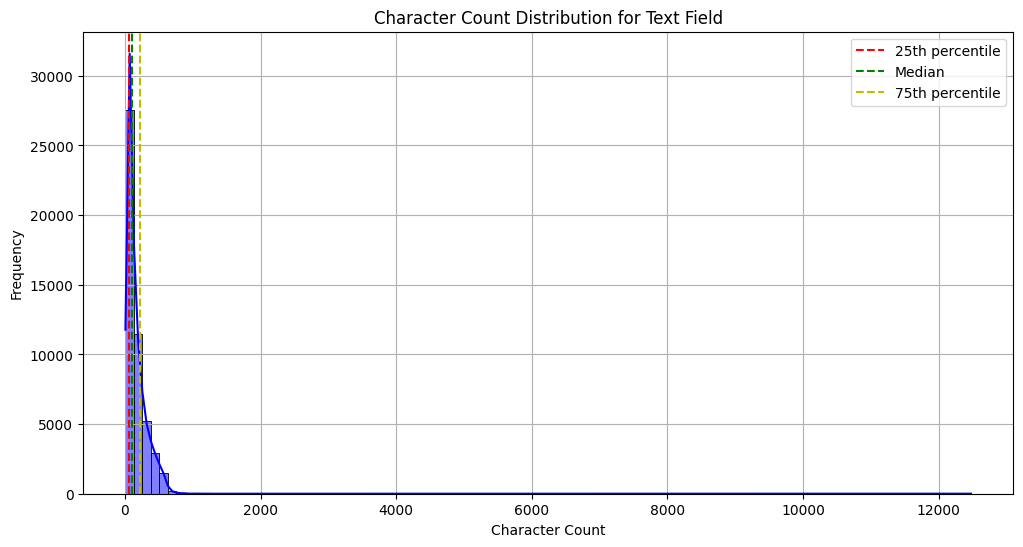

In [124]:
# Calculate character lengths
char_lengths = filtered_data['text'].str.len()

# Plot the character length distribution
plt.figure(figsize=(12, 6))
sns.histplot(char_lengths, bins=100, kde=True, color='blue')
plt.title('Character Count Distribution for Text Field')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid(True)

# Add vertical lines for quartiles
plt.axvline(char_lengths.quantile(0.25), color='r', linestyle='--', label='25th percentile')
plt.axvline(char_lengths.quantile(0.5), color='g', linestyle='--', label='Median')
plt.axvline(char_lengths.quantile(0.75), color='y', linestyle='--', label='75th percentile')
plt.legend()


# Print results in tabular format
print("\nCharacter length statistics:")
print(tabulate([char_lengths.describe()], headers='keys'))

In [125]:
# print records exceeding 1024 characters
print("\nRecords exceeding 1024 characters:")

limit_exceeded = filtered_data[char_lengths > 1024]

print("No.of Records Exceeding 1024 Characters:", len(limit_exceeded))

# Display the first few records
print(limit_exceeded['text'])


Records exceeding 1024 characters:
No.of Records Exceeding 1024 Characters: 16
316      Beginners tutorial on using OpenAI DALLE with ...
626      Application error: a client-side exception has...
953      Microsoft announces new tool for applying Chat...
1029     Claims about the capabilities of open source L...
1366     Correctly using generative AI models: foundati...
1474     Who's worried that Gemini is going to be/get s...
1740     I think I got access to DALL-E 3, it's incredi...
1966     New API GPT-4 Turbo 128K Context and API Code ...
2043     I have been fascinated to see that ChatGPT dis...
2622     Anthropic updates it terms of use today. Seem ...
7498     ChatGPT o1-mini is silently getting nerfed aga...
8038     How many places can ChatGPT calculate Pi? Aske...
8435     DeepSeek is much smarter than it's content-fil...
8771     text-embedding-ada-002    * **Better:** it out...
11058    Looks like you already found the "add a delay"...
13108    Be gone crap.  &#x200B;  r

In [126]:
# Remove records where text exceeds 1024 characters
filtered_data = filtered_data[char_lengths <= 1024]

# Display the number of records after filtering
print("\nNumber of Posts and Comments after filtering by character count:")
print("Posts:", filtered_data["post_id"].nunique())
print("Comments:", filtered_data["comment_id"].nunique())
print("\nNumber of records removed:", len(limit_exceeded))
print("\nTotal records:", len(filtered_data))


Number of Posts and Comments after filtering by character count:
Posts: 8571
Comments: 42709

Number of records removed: 16

Total records: 48853


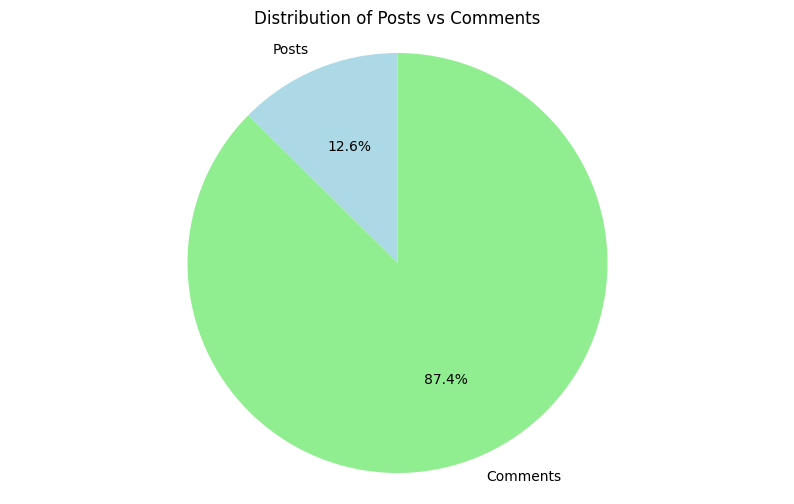

In [127]:
# Count posts vs comments from post_or_comment column
# Create a Series for posts vs comments distribution
data = pd.Series({
    'Posts': filtered_data["comment_id"].isna().sum(),
    'Comments': filtered_data["comment_id"].notna().sum()
})

# Create pie chart
plt.figure(figsize=(10, 6))
plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
plt.title("Distribution of Posts vs Comments")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

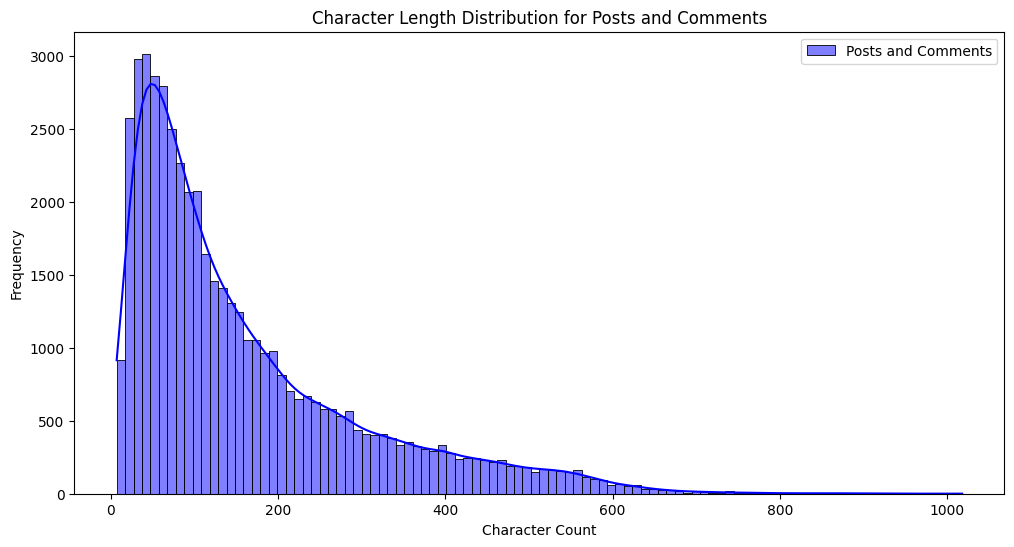

In [128]:
# Character length distribution for posts and comments
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['text'].str.len(), bins=100, kde=True, color='blue', label='Posts and Comments')
plt.title('Character Length Distribution for Posts and Comments')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.legend()

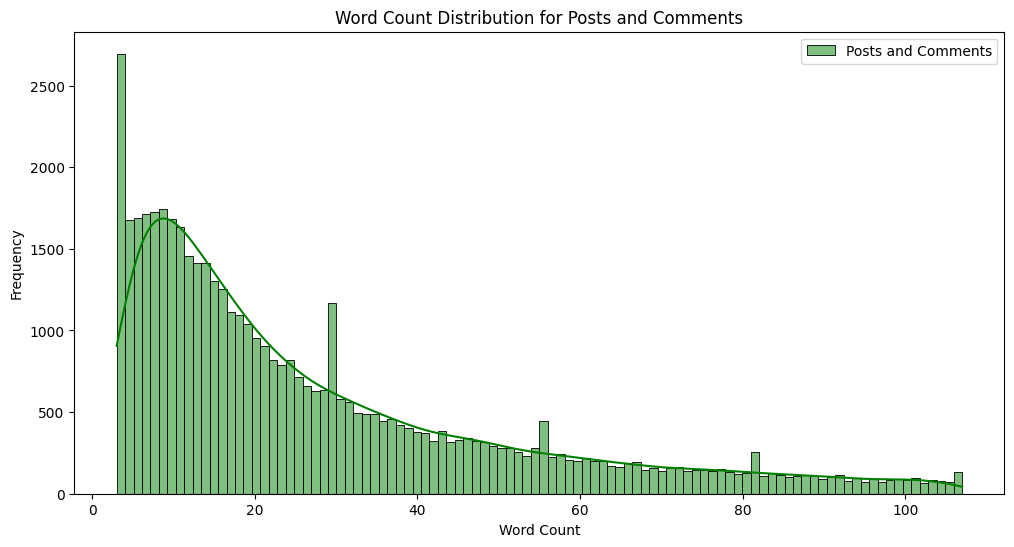

In [129]:
# Word count distribution for posts and comments
plt.figure(figsize=(12, 6))
sns.histplot(filtered_data['text'].str.split().str.len(), bins=100, kde=True, color='green', label='Posts and Comments')
plt.title('Word Count Distribution for Posts and Comments')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

In [130]:
# Tabulate Missing Values for each column
missing_values = filtered_data.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Display the missing values
print("\nMissing Values:")
print(missing_values)


Missing Values:
comment_id        6144
comment_body      6144
comment_author    6144
dtype: int64


In [131]:
# Store the filtered data in a new CSV file
filtered_data.to_csv('Data/filtered_data.csv', index=False)

## Tf-idf Vector

In [ ]:
# Todo

## Embedding

In [ ]:
# Todo

## Labeling

In [ ]:
# Todo

## Pipeline (Part - C)